# Random pattern explicator

A step-by-step breakdown of the random pattern generator.

Tech 411.05 *Patterns and Symmetry*, University of New Hampsire, J. Gibson, 2024-10-11

## function: dihedralgroup(n, withflip=true)

This function generates the matrices that rotate and flip an n-gon in the plane,
for a given value of n. An n-gon will have 2n such matrices: n rotations, and
those rotations flipped about the y axis. You can exclude the flips by setting 
the second argument to 'false'.

In [1]:
using LinearAlgebra, Plots

"""
Generate symmetries of the n-gon that rotate and flip the n-gon in the plane.
The return value is an array of matrices representing the elements of the group.
"""
function dihedralgroup(n, withflip=true)
    S = [-1 0; 0 1]                 # a reflection about y axis
    I = [1.0 0.0; 0.0 1.0]          # the identity
    Dn = fill(I, withflip ? 2n : n) # allocate an array of 2n or n matrices
    
    for k=1:n
        θ = 2(k-1)π/n
        Dn[k]   = [cos(θ) -sin(θ); sin(θ) cos(θ)] # rotation by θ
        if withflip
            Dn[k+n] = S*Dn[k]  # rotation by θ followed by reflection
        end
    end
    Dn
end

dihedralgroup

### Example: $D_4$, the symmetries of the square. 

For example, here's $D_4$, the symmetry group of the 4-gon, i.e. the square,
represented as 8 2x2 matrices. The printout is somewhat obscured by
numbers that are close to but not exactly zero. 

In [2]:
D4 = dihedralgroup(4)

8-element Vector{Matrix{Float64}}:
 [1.0 -0.0; 0.0 1.0]
 [6.123233995736766e-17 -1.0; 1.0 6.123233995736766e-17]
 [-1.0 -1.2246467991473532e-16; 1.2246467991473532e-16 -1.0]
 [-1.8369701987210297e-16 1.0; -1.0 -1.8369701987210297e-16]
 [-1.0 0.0; 0.0 1.0]
 [-6.123233995736766e-17 1.0; 1.0 6.123233995736766e-17]
 [1.0 1.2246467991473532e-16; 1.2246467991473532e-16 -1.0]
 [1.8369701987210297e-16 -1.0; -1.0 -1.8369701987210297e-16]

The printout is somewhat obscured by numbers that are close to but not exactly zero.
Let's reprint rounding the elements to 0 and $\pm1$.

In [3]:
for k in 1:8
    @show Int.(round.(D4[k]))
end

Int.(round.(D4[k])) = [1 0; 0 1]
Int.(round.(D4[k])) = [0 -1; 1 0]
Int.(round.(D4[k])) = [-1 0; 0 -1]
Int.(round.(D4[k])) = [0 1; -1 0]
Int.(round.(D4[k])) = [-1 0; 0 1]
Int.(round.(D4[k])) = [0 1; 1 0]
Int.(round.(D4[k])) = [1 0; 0 -1]
Int.(round.(D4[k])) = [0 -1; -1 0]


## function: symmetrize(X,G)

This function takes a set $X$ of points on the plane and maps them through a set of symmetries $G$. 

$X$ is a $2 \times N$ matrix of data points $(x_j, y_j)$, in form

\begin{align*}
X = \begin{bmatrix}x_1 & x_2 & x_3 & \ldots & x_N \\ y_1 & y_2 & y_3 & \ldots & y_N\end{bmatrix}
\end{align*}

and $G$ is a set of symmetries, $G = G[1], G[2], \ldots$, where each $G[k]$ is a 2 x 2 matrix. 
For example, $G$ might be the dihedral group $D_4$.

The function maps each data point $X_j = (x_j, y_j)$ in $X$ through each symmetry $G[k]$ and returns 
set of all mapped data points in the matrix $GX$.

In [4]:
# Symmetrize a set of data points X by symmetry group G
function symmetrize(X, G)
    m,nX = size(X)  # nX is number of data points
    nG = length(G)  # nG is number elements in group
    
    GX = fill(0.0, 2, nX*nG) # allocate a matrix for G applied to X
    
    for j in 1:nX      # for each point in X
        for k in 1:nG  # and for each matrix in the group
            GX[:, (j-1)*nG + k] = G[k]*X[:,j] # map the jth datapoint by the kth matrix
        end
    end
    GX
end

symmetrize (generic function with 1 method)

### Example: symmetrize 3 random points with $D_4$

Let's observe how that works with some plots. First set up an $X$ matrix with three 
random data points.

In [5]:
X = randn(2,3)

2×3 Matrix{Float64}:
 -2.08765  -1.88264  -0.203449
  0.21634   1.12679  -1.06311

A plot of these these data points.

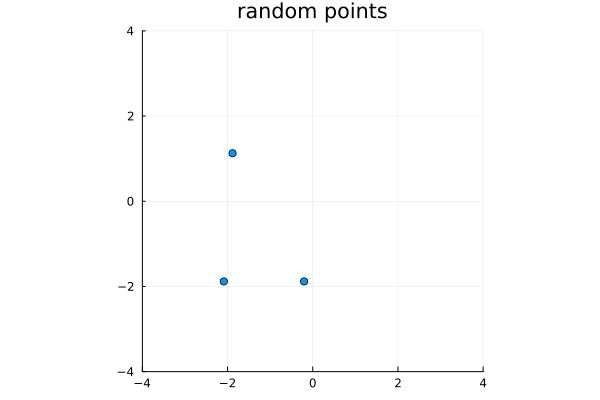

In [6]:
w = 4
scatter(X[1,:], X[:,2], aspect_ratio=1, title="random points", label="")
p1 = plot!(aspect_ratio=1, xlim=(-w,w), ylim=(-w,w))

Now apply the 8 symmetries of the square (the group $D_4$) to the 3 data points and replot. 

I'll label the output Xsymm, standing for X symmetrized. Three data points times 8 symmetries
produces 24 symmetrized data points. 

In [7]:
Xsymm = symmetrize(X,D4)

2×24 Matrix{Float64}:
 -2.08765  -0.21634   2.08765  0.21634  …  -1.06311   -0.203449  1.06311
  0.21634  -2.08765  -0.21634  2.08765     -0.203449   1.06311   0.203449

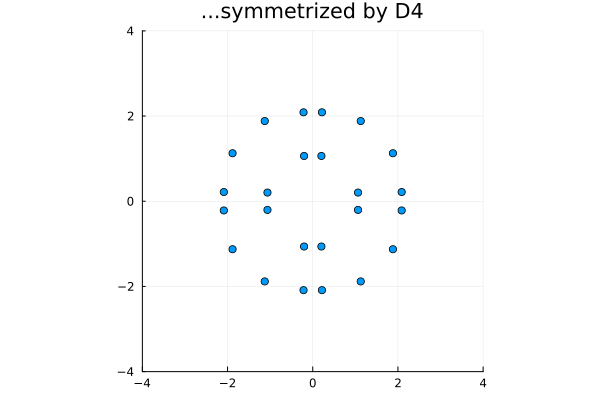

In [8]:
scatter(Xsymm[1,:], Xsymm[2,:], title="...symmetrized by D4", label="")
p2 = plot!(xlim=(-w,w), ylim=(-w,w), aspect_ratio=1)

By mapping all the random data points through all the symmetries of the square, 
we have made a set of random data points with the symmetries of the square!

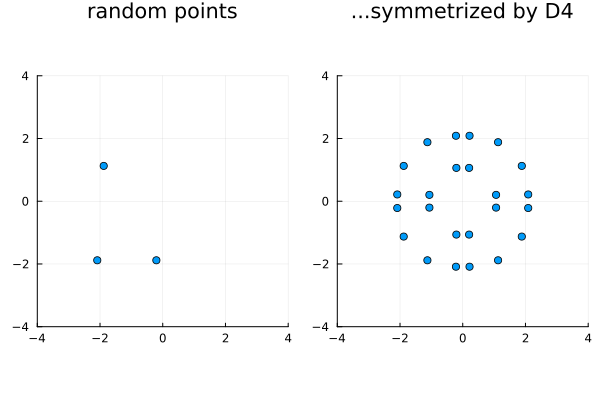

In [9]:
plot(p1,p2)

## function f(x): centering ripples about data points

The following function assigns a numerical value $z = f(x)$ to every point
$x$ in the plane, based on the distance from $x$ to every point $X_j$ in
the matrix $X$. 

\begin{align*}
f(x) = \sum_{j=1}^n \cos(k\|x-X_j\|) \; e^{-a \|x-X_j\|^2}
\end{align*}

Here $x = (x_1, x_2)$ is a point in the plane, $X_j$ is also a point in the plane, 
and $\|x-X_j\|$ is the distance between $x$ and $X_j$.

The Julia function for `f` has a few extra parameters, `X` for the matrix of data points
and `a` and `k` to specify the scale of oscillations in the cosine and the decay rate
in the exponential. 

In [10]:
function f(x, X, a=1, k=1)
    s = 0.0
    for j in 1:size(X, 2)
        r = norm(x-X[:,j])
        s += cos(k*r)*exp(-a*(r^2))
    end
    s
end

f (generic function with 3 methods)

### f(x) in one dimension

The function $f(x)$ is probably best understood through plotting. Let's start with
the one-dimensional version with just one data point X at the origin. In this case, 
$f(x)$ reduces to

\begin{align*}
f(x) = \cos(kx) \; e^{-a x^2}
\end{align*}

$f(x)$ is a bell curve (Gaussian distribution) $e^{-a x^2}$ modulated by an oscillation $\cos(kx)$. 

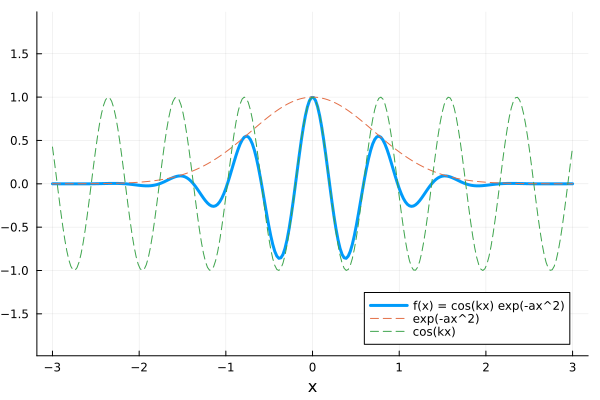

In [11]:
# define and plot a 1d version of f(x)

a = 1   # scale of Gaussian envelope (large a => narrow Gaussian)
k = 8   # scale of oscillation (large k => faster oscillation, finer ripples)
w = 3   # width of plot (plot over -w ≤ x ≤ w)

f(x, a, k) = cos(k*x)*exp(-a*x^2)

x = range(-3,3, 256)
plot(x, f.(x,a,k), linewidth=3, label= "f(x) = cos(kx) exp(-ax^2)")
plot!(x, exp.(-a*x.^2), linestyle=:dash, label="exp(-ax^2)")
plot!(x, cos.(k*x), linestyle=:dash, label="cos(kx)")
plot!(aspect_ratio=1, xlabel="x")


You can see that how $f(x) = \cos(kx) e^{-ax^2}$ has the oscillation of $\cos(kx)$,
but the amplitude of the oscillation decays as $|x|$ increases according to $e^{-ax^2}$.

**Activity:** Try playing around with the values of $a$ and $k$ and replotting.
You should see that parameter $a$ controls how quickly the shape tapers to zero
towards the edges, and $k$ controls how rapidly the curve oscillates up and down
with $x$.

### f(x) in two dimensions

The two-dimensional version of $f(x)$ is just the 1d version spun about 
its central axis. Let $\|x\|$ be the norm, or length, of the vector $x$, namely
$\|x\| = \sqrt{x_1^2 + x_2^2}$. Then

\begin{align*}
f(x) = \cos(k\|x\|) \; e^{-a \|x\|^2}
\end{align*}

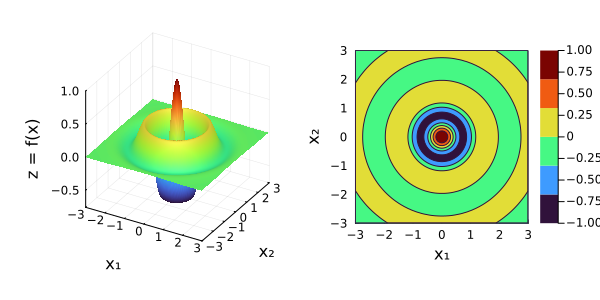

In [12]:
Xorigin = [0 0; 0 0]
a = 0.5
k = 4
w = 3

# make vectors of gridpoints for x1 (x coordinate) and x2 (y coordinate)
x1grid = range(-w, w, length=100)
x2grid = range(-w, w, length=100)

# evaluate f(x) over the 2d grid and store in a matrix
zgrid = [f([x1;x2], Xorigin, a, k) for x2 in x2grid, x1 in x1grid]

# set som plotting parameters
w = 3      # scale of plot: -r < x < r, -r < y < r, 
levels = 5 # number of colorlevels
colormap = :turbo

zscale = maximum(abs.(zgrid))  # maximum abs val of f(x) over plane

surface(x1grid, x2grid, zgrid/zscale, seriescolor=colormap, legend=:none)
p1 = plot!(xlim=(-w,w), ylim=(-w,w), aspect_ratio=1, xlabel="x₁", ylabel="x₂", zlabel="z = f(x)")

contourf(x1grid, x2grid, zgrid/zscale, color=colormap, levels=levels)
plot!(legend=:none, xlim=(-w,w), ylim=(-w,w), clim=(-1,1), aspect_ratio=1)
p2 = plot!(xlabel="x₁", ylabel="x₂")

plot(p1,p2, layout=(1,2), size=(600,300))

Again, we're viewing a 2d form of $f(x)$ now, $f(x) = \cos(k\|x\|) \; e^{-a \|x\|^2}$
where $x = (x_1, x_2)$ are the coordinates of the plane, and $\|x\| = \sqrt{x_1^2 + x_2^2}$ is the
distance from point $x = (x_1, x_2)$ to the origin. 

The left plot is a surface plot, which shows the value of $z=f(x)$ as a colored surface over
the plane $x = (x_1, x_2)$.

The right plot is a contour plot, which shows the value of $z = f(x)$ as a color over the
plane $x = (x_1, x_2)$. It's essentially a bird's-eye view of the surface plot on the left.

**Activity:** Play around with the values of $a$ and $k$ in the above code cell and see how their values affect the plots.

### The complete function $f(x)$ 

Now we go back to the complete function 
\begin{align*}
    f(x) = \sum_{j=1}^N \cos(k\|x-X_j\|) \; e^{-a \|x-X_j\|^2}
\end{align*}
and make a plot for $N=2$ data points, $X_1 = (1,1)$ and $X_2 = (-2,-2)$

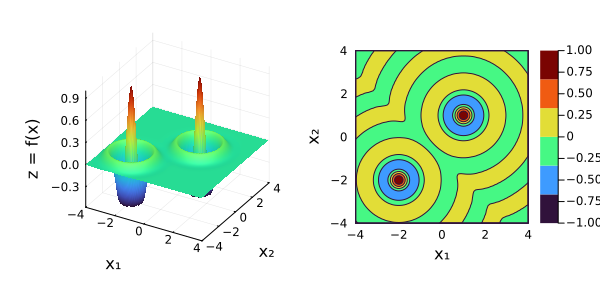

In [13]:
a = 1  # decay rate of ripples 
k = 4  # frequency of ripples
w = 4  # width of plot

X1 = [1; 1]    # drop a pebble at (1,1)
X2 = [-2; -2]  # drop a pebble at (-2,2)

X = [X1 X2]

# evaluate f(x) over the 2d grid and store in a matrix
x1grid = range(-w, w, length=100)
x2grid = range(-w, w, length=100)
zgrid = [f([x1;x2], X, a, k) for x2 in x2grid, x1 in x1grid]
zscale = maximum(abs.(zgrid))  # maximum abs val of f(x) over plane

p1 = scatter(X, label="random points")
surface(x1grid, x2grid, zgrid/zscale, seriescolor=colormap, legend=:none)
p1 = plot!(xlim=(-w,w), ylim=(-w,w), aspect_ratio=1, xlabel="x₁", ylabel="x₂", zlabel="z = f(x)")

contourf(x1grid, x2grid, zgrid/zscale, color=colormap, levels=levels)
p2 = plot!(legend=:none, xlim=(-w,w), ylim=(-w,w), clim=(-1,1), aspect_ratio=1)
plot!(xlabel="x₁", ylabel="x₂")

plot(p1,p2, layout=(1,2), size=(600,300))

Again, the function being plotted is
\begin{align*}
    f(x) = \sum_{j=1}^N \cos(k\|x-X_j\|) \; e^{-a \|x-X_j\|^2}
\end{align*}
where $x$ and $X_j$ are 2d vectors. The position in the plane is $x = (x_1, x_2)$, and
$X_1 = (1,1)$ and $X_2 = (-2,-2)$ are data points specifying the centers of oscillating
bumps. 

You can think of the two data points $X_1$ and $X_2$ as the location of two pebbles dropped
in pond, and $f(x)$ describes a pattern of the decaying ripples centered about the pebbles. The
pattern of the surface $f(x)$ is formed from the superposition of the two ripple patterns.

**Activity:** Play around with the parameters $a,k$ and the data points $X_1$, $X_2$ in the
above plot to see how they affect the circular pattern centered on each data point, and the
superposition of the ripples over the whole plane. 

### Replot with symmetrized pebbles

Now let's repeat the process using pebbles dropped in a symmetric pattern.

We simply run our data points $X=[X_1, X_2]$ through the `symmetrize` function
to produce a set of symmetrized pebbles and replot. 

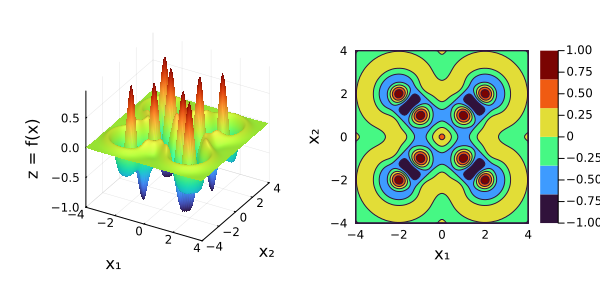

In [14]:
a = 1  # decay rate of ripples 
k = 4  # frequency of ripples
w = 4  # width of plot

X1 = [1; 1]    # drop a pebble at (1,1)
X2 = [-2; -2]  # drop a pebble at (-2,2)

X = [X1 X2]

Xsymm = symmetrize(X,D4)

# evaluate f(x) over the 2d grid and store in a matrix
x1grid = range(-w, w, length=100)
x2grid = range(-w, w, length=100)
zgrid = [f([x1;x2], Xsymm, a, k) for x2 in x2grid, x1 in x1grid]
zscale = maximum(abs.(zgrid))  # maximum abs val of f(x) over plane

p1 = scatter(X, label="random points")
surface(x1grid, x2grid, zgrid/zscale, seriescolor=colormap, legend=:none)
p1 = plot!(xlim=(-w,w), ylim=(-w,w), aspect_ratio=1, xlabel="x₁", ylabel="x₂", zlabel="z = f(x)")

contourf(x1grid, x2grid, zgrid/zscale, color=colormap, levels=levels)
p2 = plot!(legend=:none, xlim=(-w,w), ylim=(-w,w), clim=(-1,1), aspect_ratio=1)
plot!(xlabel="x₁", ylabel="x₂")

plot(p1,p2, layout=(1,2), size=(600,300))

**Activity:** Play around with the parameters $a$, $k$ and the pebble locations $X_1$ and $X_2$.

 ## Generate some random patterns
 
 The following code will generate random patterns based on a few parameters
 
   * $n$ specificies the symmetry group $D_n$, the symmetry group of the $n$-gon
   * $N$ specifies the number of random data points on the plane
   * $a$ specifies the scale of the blobs over each data point: large $a$ means narrower blobs
   * $k$ specifies the scale of the oscillation in each blob: large $k$ means more rapid wiggles
   * $s$ specifies the scale of the random data points: large $s$ spreads the points out further in the plane
   * *flip* specifies whether or not to include reflections (flips) in the symmetry group
   * `colormap` specifies the map from a numeric value of $f(x)$ to a color. Search on "Julia Plots colormap" to find different choices.
   
Every time you execute this cell, it'll generate a new pattern based on a new set of random data points. 

Experiment with different choices of parameters, generate the coolest patterns you can!


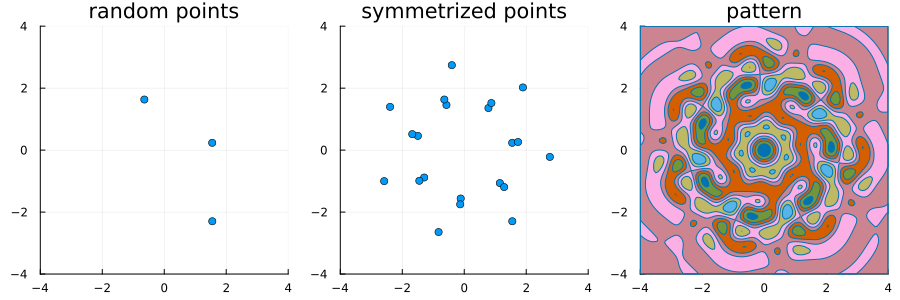

In [15]:
# pattern parameters
n = 7   # n-gon dihedral group
N = 3   # number of random points
a = 1/2   # scale of blobs (larger a, narrower blobs)
k = 6  # scale of wiggles (larger k, more rapid wiggles)
s = 1   # scale of data points (larger s, further spread out)
flip = false

# plotting parameters
w = 4   # length scale of plot: -r < x < r, -r < y < r, 
levels = 6 # number of colorlevels
colormap = :seaborn_colorblind

G = dihedralgroup(n, flip)

X = s*randn(2,N)
Xsymm = symmetrize(s*X,G)

x1grid = range(-w, w, length=128)
x2grid = range(-w, w, length=128)

zgrid = [f([x1;x2], Xsymm, a, k) for x2 in x2grid, x1 in x1grid]
zscale = maximum(abs.(zgrid))

p1 = scatter(X[1,:], X[2,:], xlim=(-w,w), ylim=(-w,w), label="", title="random points", aspect_ratio=1)
p2 = scatter(Xsymm[1,:], Xsymm[2,:], xlim=(-w,w), ylim=(-w,w), label="", title="symmetrized points", aspect_ratio=1)
contourf(x1grid, x2grid, zgrid/zscale, color=colormap, levels=levels, legend=:none, title="pattern")
p3 = plot!(legend=:none, xlim=(-w,w), ylim=(-w,w), aspect_ratio=1)
plot(p1,p2,p3, layout=(1,3), size=(900,300))

**Activity:** Play around with the pattern parameters $n, N, a, k, s,$ and `flip`.
See what cool plots you can generate! What combination of parameters gives the 
most interesting patterns?

Save any patterns you particularly like with

In [16]:
plot(p3, size=(1600,1600))
savefig("pattern.png")

"/home/gibson/professional/teaching/2024-25/patterns-and-symmetry/06-random-patterns/pattern.png"